In [ ]:
!pip install h5py

In [75]:
import re
import numpy as np
f = open('sonnets.txt')
text = f.read().lower().replace('\t','')
text = re.sub(r'[^\w\s]', '', text)
text = re.sub(r"sonnet.*\n", 'newpoem\n', text)
vocab = list(set(text))
print(vocab)
text = [i for i in text.split("\n") if i!=""]
text.pop(0)
#print(text)
sonnets = []
temp = ""
for i in text:
  if i != "newpoem":
    temp += i+" \n"
  else:
    sonnets.append(temp)
    temp = ""
print(len(sonnets))

['u', 'h', '\n', 'p', 'z', 'k', 'i', 'r', 's', 'y', 'm', 'x', 'j', 'b', 'f', 'v', 'e', 'd', 'a', 'l', 'w', 'q', ' ', 'g', 'n', 'o', 'c', 't']
154


In [76]:
i2c_dict = {}
c2i_dict = {}
for i in range(len(vocab)):
  i2c_dict[i] = vocab[i]
  c2i_dict[vocab[i]] = i
vocab_size = len(vocab)

In [77]:
def one_hot(a,vocab_size):
  a = np.array(a)
  b = np.zeros((a.size, vocab_size))
  b[np.arange(a.size),a] = 1
  return b
X = []
Y = []
counter = 1
for i in sonnets:
  print("\r"+str(counter)+"/154",end="")
  counter = counter + 1
  for j in range(50,len(i)):
    x_val = [c2i_dict[k] for k in i[j-50:j]]
    y_val = one_hot([c2i_dict[i[j]]],vocab_size)
    X.append(x_val)
    Y.append(y_val)
X_array = np.array(X).reshape(len(X),50,1)
Y_array = np.array(Y).reshape(len(Y),vocab_size)

154/154

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_array, Y_array, test_size=0.1, random_state=10)

In [79]:
from keras import Model
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam

In [80]:
def nextinput(x,pred):
    x = x[1:]
    pred = np.argmax(pred)
    x = np.append(x,pred)
    return x,pred
def printarray(arr):
    #arr = np.argmax(arr,axis=1)
    string = ""
    for i in arr:
      string = string + i2c_dict[i[0]]
    return string
class PredictCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        keys = list(logs.keys())
        inp = X_test[10]
        print(printarray(inp),end="")
        X_Val = np.reshape(inp,(1,50,1))
        for i in range(50):
            pred = self.model.predict([X_Val],verbose = 0)
            pred = np.reshape(pred,(28,1))
            inp,pred = nextinput(inp,pred)
            X_Val = np.reshape(inp,(1,50,1))
            character = i2c_dict[pred]
            print(character,end="")
        print("\n")

In [81]:
def create_model(inp_shape,batch_size,vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size,256,input_length=50))
    model.add(LSTM(512, input_shape = (None,50,256), activation = 'relu'))
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2048,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(vocab_size,activation='softmax'))
    return model
BATCH_SIZE = 64
checkpoint_path = "model.20-0.61.h5"
model = create_model(X_array[0].shape,BATCH_SIZE,vocab_size)
model.load_weights(checkpoint_path)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 256)           7168      
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
dense_44 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dropout_33 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_34 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 2048)            

In [82]:
opt = Adam(learning_rate=0.0005)
checkpoint = ModelCheckpoint(filepath='model.{epoch:02d}-{loss:.2f}.h5')
callbacks_list = [checkpoint,PredictCallback()]
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
history = model.fit(x=X_train,y=y_train,epochs=20,validation_split=0.1,batch_size=BATCH_SIZE,validation_steps=20,callbacks=callbacks_list,shuffle=True)

Epoch 1/20
1074/1074 [==============================] - 949s 884ms/step - loss: 2.2743 - accuracy: 0.3294 - val_loss: 1.9942 - val_accuracy: 0.4016
y keep 
by childrens eyes her husbands shape in ming 
the the the the the the the the the the the th

Epoch 2/20
1074/1074 [==============================] - 928s 864ms/step - loss: 1.8372 - accuracy: 0.4473 - val_loss: 1.7676 - val_accuracy: 0.4563
y keep 
by childrens eyes her husbands shape in mine 
the the the the the the the the the still 
the

Epoch 3/20
1074/1074 [==============================] - 920s 856ms/step - loss: 1.6691 - accuracy: 0.4894 - val_loss: 1.6512 - val_accuracy: 0.4914
y keep 
by childrens eyes her husbands shape in mine 
and the the the the the the the the the shall 

Epoch 4/20
1074/1074 [==============================] - 912s 850ms/step - loss: 1.5725 - accuracy: 0.5100 - val_loss: 1.5786 - val_accuracy: 0.5141
y keep 
by childrens eyes her husbands shape in mine 
and the stear the stear the stell the stell 
t



265/265 [==============================] - 34s 128ms/step


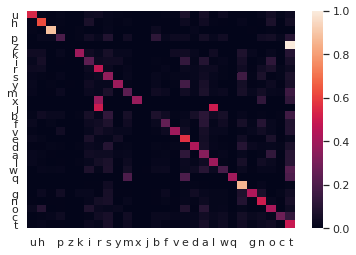

In [83]:
import seaborn as sns; sns.set_theme()
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test,verbose = 1)
y_pred_val = np.argmax(y_pred,axis=1)
y_test_val = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_test_val, y_pred_val)
cm = (cm.T/cm.sum(axis=1)).T
sns.heatmap(cm,xticklabels=vocab, yticklabels=vocab)

In [93]:
input_text = "From fairest creatures we desire increase\nThat thereby"
input_text = input_text.lower()
no_of_char = 400
if len(input_text)>=50:
    inp = []
    for i in range(50):
        inp.append(c2i_dict[input_text[i]])
    inp = np.array(inp).reshape((50,1))
    print(printarray(inp),end="")
    X_Val = np.reshape(inp,(1,50,1))
    for i in range(no_of_char):
            pred = model.predict([X_Val],verbose = 0)
            pred = np.reshape(pred,(28,1))
            inp,pred = nextinput(inp,pred)
            X_Val = np.reshape(inp,(1,50,1))
            character = i2c_dict[pred]
            print(character,end="")
    print("\n")
else:
    print("Input is too small")

from fairest creatures we desire increase
that they me be blessed welite 
shall will in overplus of words of thy dear 
to pubst time desire the store of my good 
and to thy sweet love remembers she keep 
in the death of my purpose fair wert 
and summers breath their antique pen wiit 
beautys effectuned simplicities 
and to the love thy fair appearance find 
thy bloody spur and hours false in this 
i will acquaintance but as the living defence 
th

